<a href="https://colab.research.google.com/github/aka-gera/Data_Classification/blob/main/maternal_health_risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CLASSIFIER**

*This algorithm will identify the optimal classification machine learning model for a given dataset.*

This dataset is provided by: https://www.kaggle.com/datasets/pyuxbhatt/maternal-health-risk

In [13]:
data_dir = f'pyuxbhatt/maternal-health-risk'

# Import Dataset

In [14]:
! pip install kaggle

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
!pwd
%cd /content

/content
/content


In [17]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [18]:
! cp /content/drive/MyDrive/Kaggle_API/kaggle.json ~/.kaggle

In [19]:
! chmod 600 ~/.kaggle/kaggle.json

In [20]:
! kaggle datasets download {data_dir}

Dataset URL: https://www.kaggle.com/datasets/pyuxbhatt/maternal-health-risk
License(s): unknown
100% 496k/496k [00:00<00:00, 1.23MB/s]
100% 496k/496k [00:00<00:00, 1.23MB/s]


In [21]:
import os
file_names = os.listdir()
zip_file =   [file for file in file_names if file.endswith('.zip')]
zip_file

['maternal-health-risk.zip']

In [22]:
import zipfile

# Open the zip file
with zipfile.ZipFile(zip_file[-1], 'r') as zip_ref:
    zip_ref.extractall()
    unzipped_file_names = zip_ref.namelist()
unzipped_file_names

['Maternal Health Risk Data Set.csv', 'Maternal health.ipynb', 'README.md']

# Import the helper classes

In [23]:
!pwd
%cd /content/drive/MyDrive/ML2023/data-analysis

/content
/content/drive/MyDrive/ML2023/data-analysis


In [24]:
!pip install AutoLogging-ML
!pip install xgboost
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.5 MB/s eta 0:00:00


In [25]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import math
from plotly.subplots import make_subplots
from AutoLogging_ML import AutoLogger
import seaborn as sns

from aka_data_analysis.aka_plot import aka_plot, aka_correlation_analysis
from aka_data_analysis.aka_learning import aka_learn,aka_clean,aka_filter

aka_plot = aka_plot()
aka_corr_an = aka_correlation_analysis()
aka_clean = aka_clean()
aka_learn = aka_learn()
aka_filter = aka_filter()
aka_corr_an = aka_correlation_analysis()

In [26]:
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import plotly.figure_factory as ff
import plotly.express as px
import numpy as np
import pandas as pd


# Dataset Information

In [44]:
df = aka_clean.df_get(f'/content/{unzipped_file_names[0]}')

In [45]:
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


In [30]:
fig = aka_plot.Plot_histogram_Features(df,[0,1,2,5,6] )
if fig is not None:
    fig.show()

In [31]:
df.describe()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,98.665089,74.301775
std,13.474386,18.403913,13.885796,3.293532,1.371384,8.088702
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000


# Clean Dataset

## Drop Duplicate data

In [46]:
df.drop_duplicates()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk
...,...,...,...,...,...,...,...
673,12,100,50,6.4,98.0,70,mid risk
674,15,100,60,6.0,98.0,80,low risk
703,15,100,49,7.6,98.0,77,low risk
704,12,100,50,6.0,98.0,70,mid risk


## Swap the target and the last feature

In [47]:
df = aka_clean.swap_features(df,-1)
df.head()

Invalid feature indices or feat_a is equal to feat_b.


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


### Drop feature(s)


In [48]:
feat =  []
df = aka_clean.drop_feature(df,feat)
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


##  Convert categorical variables into numerical representations

In [49]:
mapping,swapMapping = aka_clean.CleaningVar(df)
df = aka_clean.CleaningDF(df,mapping)
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,0
1,35,140,90,13.0,98.0,70,0
2,29,90,70,8.0,100.0,80,0
3,30,140,85,7.0,98.0,70,0
4,35,120,60,6.1,98.0,76,1


## Balance Dataset

In [50]:
aka_plot.plot_pie(df,-1)

In [41]:
# df = aka_clean.balance_df(df,'j')
# aka_plot.plot_pie(df, -1)

## Correlation Matrix

In [51]:
aka_corr_an.Plot_Correlation_Matrix(df)

In [52]:

confidence_interval_limit =   [-5,5]             # Define the limits m of the confidence interval [-m, m] and eliminate the outliers'''

correlation_percentage_threshold = .8      # Set the limit of the correlation between the feature to be removed

df_filtered,corr_tmp = aka_learn.filter_drop_corr_df(df,confidence_interval_limit,correlation_percentage_threshold)

diff_shape = (df.shape[0]-df_filtered.shape[0],df.shape[1]-df_filtered.shape[1])
diff_shape,df_filtered.shape

((2, 0), (1012, 7))

## Graph the features that are highly correlated


In [53]:
fig = aka_corr_an.Plot_Correlate_Features(df,list(corr_tmp))
if fig is not None:
    fig.show()

Empty list is provided.


### Visualize the distribution of the filtered dataset

In [54]:
aka_plot.Plot_box_Features(df,df_filtered,corr_tmp=range(df_filtered.shape[1]))

# Search for the most effective ML algorithm to learn the dataset

In [55]:
pre_proc = 'X'                             # Choose between 'XY' to standardize both 'X' and 'Y',
                                              #                'X' to standardize only 'X',
                                              #                'Y' to standardize only 'Y',

X_train, X_test, y_train, y_test = aka_learn.Learning_data(df_filtered,pre_proc)

In [56]:
r,model =AutoLogger.train_and_log_classification(X_train,y_train,X_test,y_test,size='large')
y_pred = model.predict(X_test)

In [57]:
model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

<Axes: xlabel='validation-accuracy', ylabel='model'>

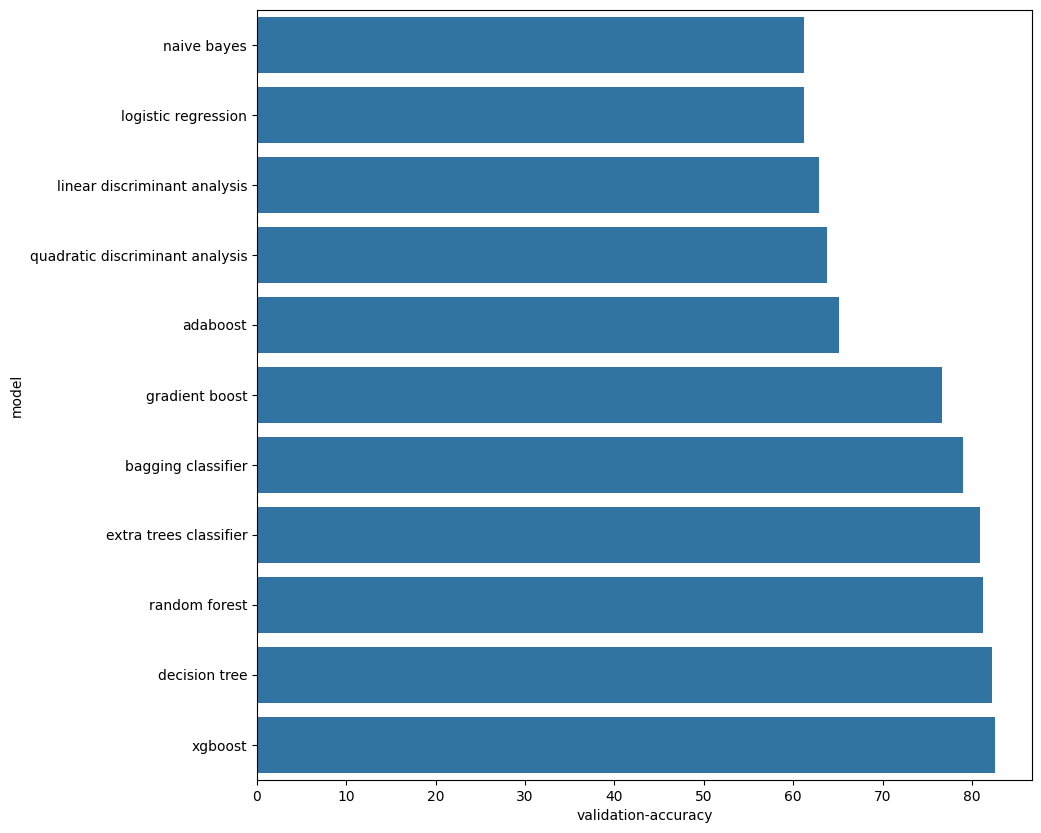

In [58]:
AutoLogger.get_metric_plot_classification(r,'validation','accuracy')

## Confusion Matrix

In [59]:
y_pred_ = aka_clean.swap_map(y_pred,swapMapping)
y_test_ = aka_clean.swap_map(y_test,swapMapping)
Label = [str(un) for un in np.unique(pd.concat([y_pred_, y_test_]))]

In [60]:
Label

['high risk', 'low risk', 'mid risk']

In [61]:
shw = 1
fig2 =  aka_plot.plot_confusion_matrix(y_test_,y_pred_,Label,shw)
fig2.show()

## Classification Report

In [62]:
shw = 1
fig3 =  aka_plot.plot_classification_report(y_test_,y_pred_,Label,shw)
fig3.show()

## Plot Important Features by Weight

In [64]:
aka_plot.plot_important_features(model,df_filtered)